In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from datetime import datetime

pd.set_option('display.max_colwidth', None)

In [2]:
# Load the datasets
start_time = time.time()
df_mkt = pd.read_excel('Pricing Data Sets.xlsx')
print('loading time of first sheet is: {}'.format(time.time()-start_time))

start_time = time.time()
df_price_comp = pd.read_excel('Pricing Data Sets.xlsx',sheet_name=1)
print('loading time of second sheet is: {}'.format(time.time()-start_time))

start_time = time.time()
df_top = pd.read_excel('Pricing Data Sets.xlsx',sheet_name=2)
print('loading time of third sheet is: {}'.format(time.time()-start_time))

loading time of first sheet is: 95.70973420143127
loading time of second sheet is: 89.49687027931213
loading time of third sheet is: 74.16451573371887


In [3]:
# Initial clean up of market prices dataset
df_mkt.dropna(subset=[' HD Price'],axis = 0, inplace= True)
df_mkt.reset_index(drop=True,inplace=True)
df_mkt.rename(columns={' HD Price':'HD_Price'}, inplace=True)
df_mkt = df_mkt.merge(df_price_comp[['HD_CA','Product_Category L1','Product_Category L2']],how='left',left_on = 'sku',right_on='HD_CA')
df_mkt.drop('HD_CA',axis=1,inplace=True)

# Identify the items with price change
sku_price_num = df_mkt.groupby('sku')['HD_Price'].nunique().sort_values(ascending=False).reset_index()
sku_price_num['More_than_1'] = sku_price_num['HD_Price'] > 1

(0.0, 100.0)

<Figure size 1080x432 with 0 Axes>

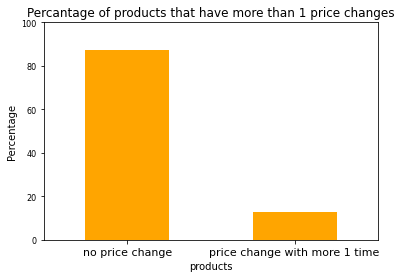

In [153]:
plt.figure(figsize=(15,6))
pd.DataFrame(sku_price_num.groupby('More_than_1')['More_than_1'].count()/len(sku_price_num)*100).plot(kind='bar',
                                                                                                      legend=False, 
                                                                                                      color='orange')
plt.title('Percantage of products that have more than 1 price changes',fontsize=12)
plt.xticks(np.arange(2),['no price change','price change with more 1 time'],rotation=360, fontsize=11)
plt.yticks(fontsize=8)
plt.xlabel('products')
plt.ylabel('Percentage')
plt.ylim(0,100)

<b>Obervation: </b>

Over 80% of products do not have a change of market prices within the period. It suggests that the pricing adjustment should depend on other factors 

#### top 100 SKU items price adjustment 

In [9]:
# Extract the market prices of top 100 SKU products 
top_sku = list(set(df_top['SKU #']))
df_mkt_top_sku = df_mkt[df_mkt['sku'].apply(lambda x: x in top_sku)]
df_mkt_top_sku.reset_index(drop = True, inplace=True)

# Seperate the Montreal prices
df_mkt_top_sku_mtl = df_mkt_top_sku[df_mkt_top_sku['store'] == 'MONTREAL']
df_mkt_top_sku_mtl.reset_index(drop = True, inplace=True)
df_mkt_top_sku_mtl.iloc[3,3] = 3.99 # replace the typo
# flag the date with price update
df_mkt_top_sku_mtl['price_change'] = df_mkt_top_sku_mtl.groupby('sku')['HD_Price'].diff(1) 

# Seperate the Toronto prices 
df_mkt_top_sku_tor = df_mkt_top_sku[df_mkt_top_sku['store'] == 'TORONTO']
df_mkt_top_sku_tor.reset_index(drop = True, inplace=True)
df_mkt_top_sku_tor.iloc[746,3] = 61.39 # replace the typo
# flag the date with price update
df_mkt_top_sku_tor['price_change'] = df_mkt_top_sku_tor.groupby('sku')['HD_Price'].diff(1)

C:\Anaconda\envs\GJ\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Anaconda\envs\GJ\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda\envs\GJ\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [12]:
# Calculate the standard deviation of item price
# Montreal
top_sku_mtl_price_std = pd.DataFrame(df_mkt_top_sku_mtl.groupby('sku')['HD_Price'].std())
top_sku_mtl_price_std.reset_index(inplace=True)
top_sku_mtl_price_std.rename(columns={'HD_Price':'price_std'}, inplace=True)

# Toronto
top_sku_tor_price_std = pd.DataFrame(df_mkt_top_sku_tor.groupby('sku')['HD_Price'].std())
top_sku_tor_price_std.reset_index(inplace=True)
top_sku_tor_price_std.rename(columns={'HD_Price':'price_std'}, inplace=True)


# Merge the std of item price with the main dataset and rearange the column order
# Montreal
df_mkt_top_sku_mtl = df_mkt_top_sku_mtl.merge(top_sku_mtl_price_std[['sku','price_std']],on='sku')
df_mkt_top_sku_mtl = df_mkt_top_sku_mtl[['sku', 'store', 'date', 'HD_Price','price_change','price_std',
                                         'Product_Category L1','Product_Category L2']]

# Toronto
df_mkt_top_sku_tor = df_mkt_top_sku_tor.merge(top_sku_tor_price_std[['sku','price_std']],on='sku')
df_mkt_top_sku_tor = df_mkt_top_sku_tor[['sku', 'store', 'date', 'HD_Price','price_change', 'price_std',
                                         'Product_Category L1','Product_Category L2']]


#anomaly_sku = df_mkt_top_sku_mtl[df_mkt_top_sku_mtl['price_std']>2]['sku'].unique()[0]
#df_mkt_top_sku_mtl[df_mkt_top_sku_mtl['sku'] ==anomaly_sku]

#anomaly_sku = df_mkt_top_sku_tor[df_mkt_top_sku_tor['price_std']>4]['sku'].unique()[0]
#df_mkt_top_sku_tor[df_mkt_top_sku_tor['sku'] ==anomaly_sku]

More_than_1
False    58
True     42
Name: More_than_1, dtype: int64


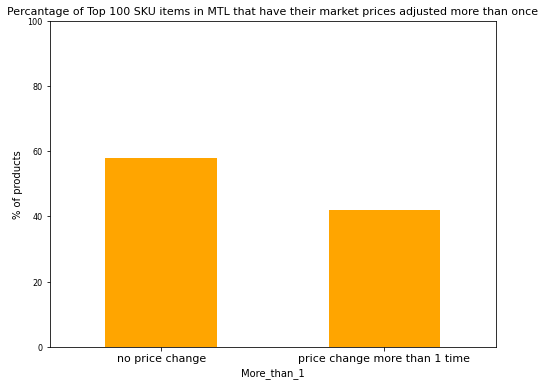

In [156]:
top_sku_mtl_price_num = df_mkt_top_sku_mtl.groupby('sku')['HD_Price'].nunique().sort_values(ascending=False).reset_index()
top_sku_mtl_price_num['More_than_1'] = top_sku_mtl_price_num['HD_Price'] > 1

pd.DataFrame(top_sku_mtl_price_num.groupby('More_than_1')['More_than_1'].count()/len(top_sku_mtl_price_num)*100).plot(kind='bar',
                                                                                                                      figsize=(8,6),
                                                                                                                      legend=False,
                                                                                                                      color='orange')

plt.title('Percantage of Top 100 SKU items in MTL that have their market prices adjusted more than once',fontsize=11)
plt.xticks(np.arange(2),['no price change','price change more than 1 time'],rotation=360,fontsize=11)
plt.yticks(fontsize=8)
plt.ylabel('% of products')
plt.ylim(0,100)

print(top_sku_mtl_price_num.groupby('More_than_1')['More_than_1'].count())

More_than_1
False    67
True     33
Name: More_than_1, dtype: int64


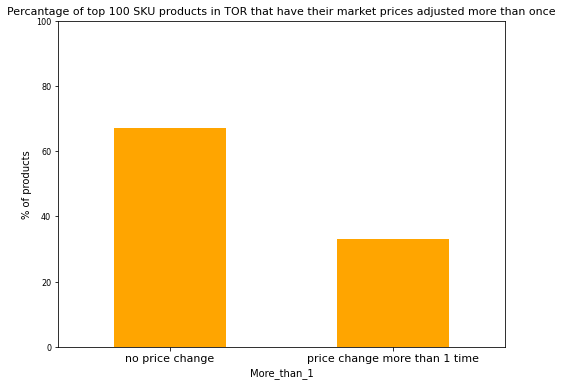

In [157]:
top_sku_tor_price_num = df_mkt_top_sku_tor.groupby('sku')['HD_Price'].nunique().sort_values(ascending=False).reset_index()
top_sku_tor_price_num['More_than_1'] = top_sku_tor_price_num['HD_Price'] > 1

pd.DataFrame(top_sku_tor_price_num.groupby('More_than_1')['More_than_1'].count()/len(top_sku_tor_price_num)*100).plot(kind='bar',
                                                                                                                      figsize=(8,6),
                                                                                                                      legend=False,
                                                                                                                      color='orange')
plt.title('Percantage of top 100 SKU products in TOR that have their market prices adjusted more than once',fontsize=11)
plt.xticks(np.arange(2),['no price change','price change more than 1 time'],rotation=360,fontsize=11)
plt.yticks(fontsize=8)
plt.ylabel('% of products')
plt.ylim(0,100)

print(top_sku_tor_price_num.groupby('More_than_1')['More_than_1'].count())

<b>Obervation: </b>

For both cities, only about 38 % of top 100 SKU items have their market prices adjusted more than once between January and May

It indicates that the most item prices should be updated depending on other factors, such as sales, competitor response, ... 

<i> The next step is to investigate the number of price update for items by category </i>

In [40]:
# Calculate the average number of price update for each category 

# Initiate two lists to store the results 
price_change_freq_MTL_list = []
price_change_freq_TOR_list = []

for cat in product_cat_L1:
    # get average number of distinct prices per item for each category in Montreal 
    avg_change = df_mkt_top_sku_mtl[df_mkt_top_sku_mtl['Product_Category L1'] == cat].groupby('sku')['HD_Price'].nunique().mean()
    price_change_freq_MTL_list.append((cat,avg_change))
    
for cat in product_cat_L1:
    # get average number of distinct prices per item for each category in Toronto
    avg_change = df_mkt_top_sku_tor[df_mkt_top_sku_tor['Product_Category L1'] == cat].groupby('sku')['HD_Price'].nunique().mean()
    price_change_freq_TOR_list.append((cat,np.floor(avg_change)))

df_price_change_freq = pd.concat([pd.DataFrame.from_records(price_change_freq_MTL_list),\
                                  pd.DataFrame.from_records(price_change_freq_TOR_list)],axis=1)
df_price_change_freq.columns= ['Category','MTL','cat_2','TOR']
df_price_change_freq.drop('cat_2',axis=1,inplace=True)

([<matplotlib.axis.XTick at 0x1670035b908>,
 [Text(0, 0, 'Fencing and Decking'),
  Text(0, 0, 'Masonry'),
  Text(0, 0, 'Drywall'),
  Text(0, 0, 'Insulation'),
  Text(0, 0, 'Finishing Materials'),
  Text(0, 0, 'Other Construction Materials'),
  Text(0, 0, 'Caulk & Accessories'),
  Text(0, 0, 'Plywood, osb and hardboard'),
  Text(0, 0, 'Hardware'),
  Text(0, 0, 'Lumber, Framing and Metal Studs')])

<Figure size 432x288 with 0 Axes>

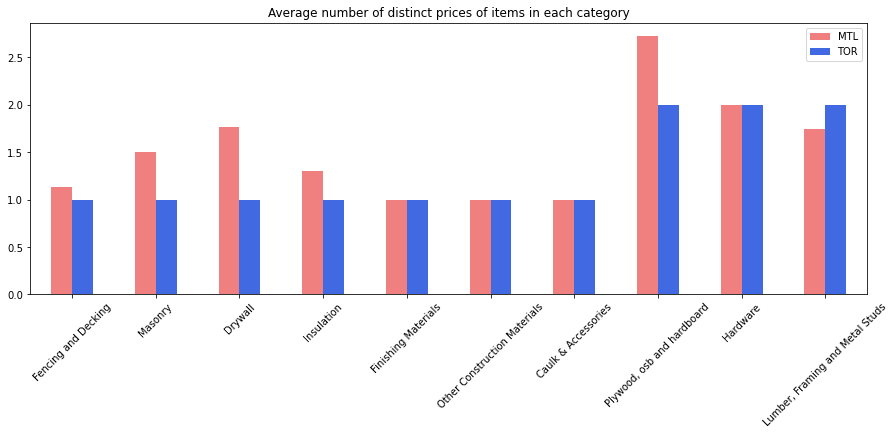

In [159]:
plt.figure()
df_price_change_freq.plot(kind='bar',figsize=(15,5), color=['lightcoral','royalblue'])
plt.title('Average number of distinct prices of items in each category')
plt.xticks(np.arange(0,10),df_price_change_freq['Category'].values,rotation=45)

<b>Obervation: </b>

Not surprisingly, Plywood, osb, and hardboard category has the highest average number of distinct prices, indicating that it has the highest frequency of price updates. 

For other categories such as finishing materials, caulk & accessories, other construction materials, their market prices are very steady (i.e. no price update)

Between two cities, Montreal tends to have more market price updates 

<i> The next step is to understand when did the price update occur for each category</i>

In [21]:
# Tracking the date of price change for Montreal prices
cat_price_change_date_mtl_dict = dict()
product_cat_L1 = list(set(df_price_comp['Product_Category L1']))

for category in product_cat_L1:
    temp_df = df_mkt_top_sku_mtl[df_mkt_top_sku_mtl['Product_Category L1'] ==category]
    temp_df.reset_index(drop=True,inplace=True)
    temp_list = df_mkt_top_sku_mtl[df_mkt_top_sku_mtl['Product_Category L1'] ==category].groupby('sku')['price_change'].apply(lambda x:(x>0) | (x<0)).values
    date_list = []
    
    for i in range(len(temp_df)):
        if temp_list[i]:
            date_list.append(temp_df['date'][i])
    
    cat_price_change_date_mtl_dict[category] = Counter(date_list)
    
df_cat_price_change_date_mtl = pd.DataFrame.from_dict(cat_price_change_date_mtl_dict).sort_index()
df_cat_price_change_date_mtl.fillna(0,inplace=True)
df_cat_price_change_date_mtl.rename(index=lambda x: datetime.strftime(x,'%Y-%m-%d'),inplace=True)

In [22]:
# Tracking the date of price change for Toronto prices
cat_price_change_date_tor_dict = dict()
    
for category in product_cat_L1:
    # get all market prices for items from each category 
    temp_df = df_mkt_top_sku_tor[df_mkt_top_sku_tor['Product_Category L1'] ==category]
    temp_df.reset_index(drop=True,inplace=True)
    
    # get all the dates when price change occured 
    temp_list = df_mkt_top_sku_tor[df_mkt_top_sku_tor['Product_Category L1'] ==category].groupby('sku')['price_change'].apply(lambda x:(x>0) | (x<0)).values
    date_list = []
    
    for i in range(len(temp_df)):
        if temp_list[i]:
            date_list.append(temp_df['date'][i])
        
    # count the number of date when price change happened
    cat_price_change_date_tor_dict[category] = Counter(date_list)
    
df_cat_price_change_date_tor = pd.DataFrame.from_dict(cat_price_change_date_tor_dict).sort_index()
df_cat_price_change_date_tor.fillna(0,inplace=True)
df_cat_price_change_date_tor.rename(index=lambda x: datetime.strftime(x,'%Y-%m-%d'),inplace=True)

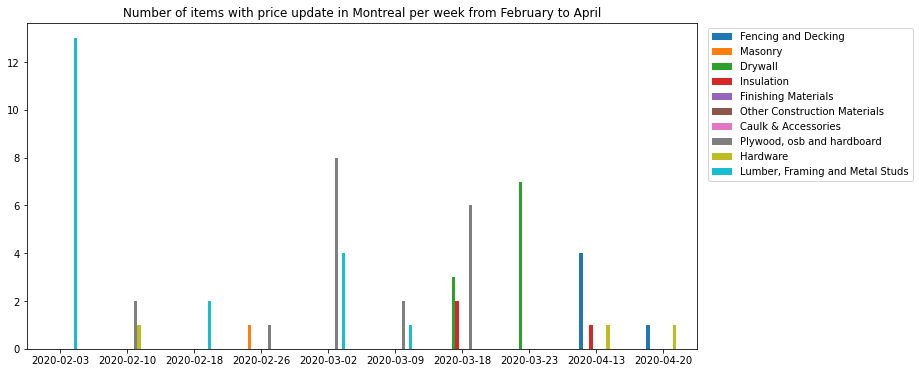

In [163]:
df_cat_price_change_date_mtl.plot(kind='bar',figsize=(12,6))
plt.title('Number of items with price update in Montreal per week from February to April')
plt.xticks(rotation=360)
plt.legend(bbox_to_anchor=(1.33,1))

<b>Obervation: </b>

In Montreal, Lumber category had the highest number of price changes before the pandemic. The prices were change every two weeks. Likewise, Plywood category had prices changed almost every week before pandemic. 

For other categories, their price change happened roughly every month.  


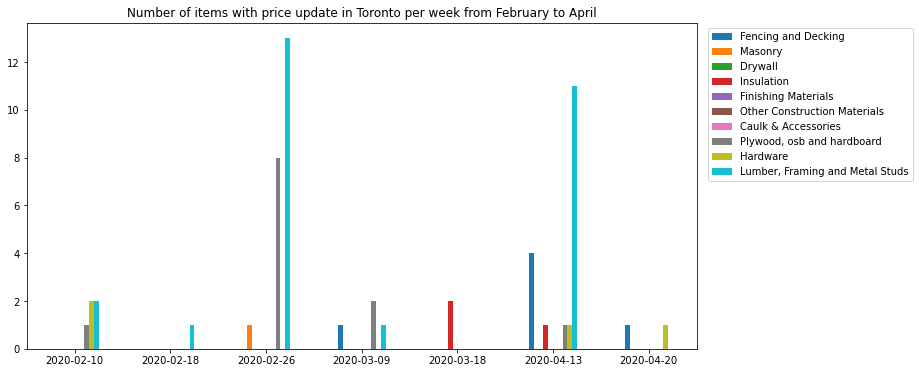

In [164]:
df_cat_price_change_date_tor.plot(kind='bar',figsize=(12,6))
plt.title('Number of items with price update in Toronto per week from February to April')
plt.xticks(rotation=360)
plt.legend(bbox_to_anchor=(1.33,1))

<b>Obervation: </b>

In Toronto, Lumber category had prices changed almost every week before pandemic, then it had another price change two weeks after.

Non-commodity items had steady market prices, such as finishing materials and other construction materials, that they did not have price change in this period.


<b> Overall Obervation: </b>

Items in Lumber and Plywood categories had frequent market price changes, while other categories seemed to have irregular pattern of price change that occured once a month.  

#### top100 SKU items valuation

In [25]:
df_top['Revenue_gained_MTL'] = df_top['MTL_total_rev']/df_top['MTL_total_units']*df_top['MTL_order_count']
df_top['Revenue_gained_TOR'] = df_top['TO_total_rev']/df_top['TO_total_units']*df_top['TO_order_count']
df_top['total_revenue_gained'] = df_top['Revenue_gained_MTL'] + df_top['Revenue_gained_TOR']
df_top['turnover_pct_MTL'] = df_top['MTL_order_count']/df_top['MTL_total_units']
df_top['turnover_pct_TOR'] = df_top['TO_order_count']/df_top['TO_total_units']
df_top['avg_turnover_pct'] = (df_top['turnover_pct_MTL']+df_top['turnover_pct_TOR'])/2

In [26]:
top_sku_valuation = df_top.copy()
top_sku_valuation = top_sku_valuation.merge(df_price_comp[['HD_CA',
                                                           'Product_Category L1',
                                                           'Product_Category L2']],
                                            how='left',left_on = 'SKU #',right_on='HD_CA')
top_sku_valuation.drop('HD_CA',axis=1,inplace=True)
top_sku_valuation = top_sku_valuation[['SKU #',
                                       'Item Name',
                                       'Product_Category L1','Product_Category L2',
                                       'MTL_order_count', 'MTL_total_rev','MTL_total_units', 
                                       'TO_order_count', 'TO_total_rev', 'TO_total_units',
                                       'Rank', 'Revenue_gained_MTL', 'Revenue_gained_TOR','total_revenue_gained', 
                                       'turnover_pct_MTL', 'turnover_pct_TOR',
                                       'avg_turnover_pct']]

Text(0.5, 0, 'Revenue ($)')

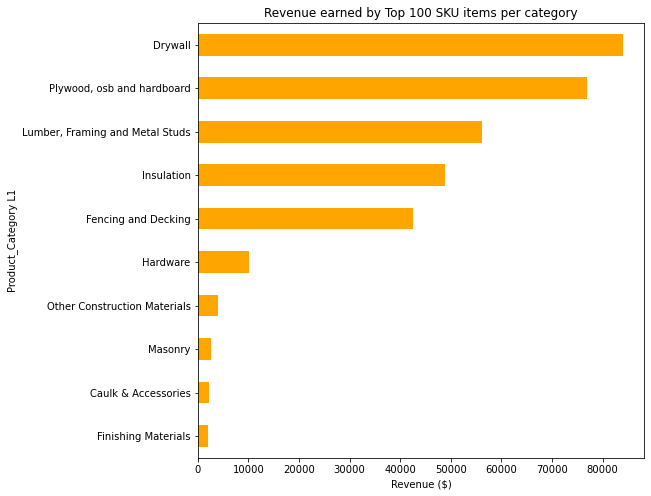

In [165]:
top_sku_valuation.groupby('Product_Category L1')['total_revenue_gained'].sum().sort_values(ascending=True).plot(kind='barh',
                                                                                                                figsize=(8,8),
                                                                                                                color = 'orange')

plt.title('Revenue earned by Top 100 SKU items per category')
plt.xlabel('Revenue ($)')

<b>Obervation: </b>

Among the Top 100 SKU items, the biggest revenue drivier is Drywall items

Text(0.5, 0, 'Turnover rate')

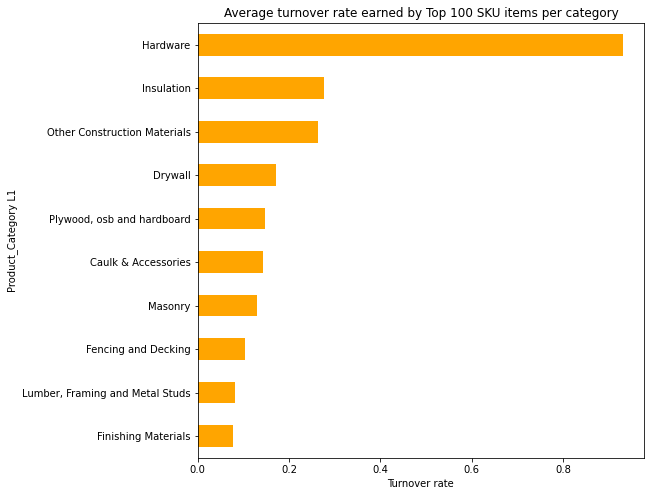

In [203]:
top_sku_valuation.groupby('Product_Category L1')['avg_turnover_pct'].mean().sort_values(ascending=True).plot(kind='barh',
                                                                                                            figsize=(8,8),
                                                                                                            color = 'orange')

plt.title('Average turnover rate earned by Top 100 SKU items per category')
plt.xlabel('Turnover rate')

In [105]:
top_sku_valuation[['SKU #','Item Name','Rank','Revenue_gained_MTL']].sort_values(by='Revenue_gained_MTL',ascending=False).head(10).reset_index(drop=True)

,SKU #,Item Name,Rank,Revenue_gained_MTL
0,1000421954,Rockwool Safe'n'Sound 16 inch O.C. For 2x4 Wood Studs,9,8867.552016
1,1000152285,1/2-inch SHEETROCK UltraLight Mould Tough 4 ft. x 8 ft. Drywall Gypsum Panel,5,7810.232479
2,1000686028,1/2-inch SHEETROCK UltraLight 4 ft. x 8 ft. Drywall Gypsum Panel,1,7693.095817
3,1000173235,"Standard Spruce Plywood 5/8"" 4 ft. x 8 ft.",11,6925.709633
4,1000401027,3/4 inches 4 ftx8 ft Standard Spruce Plywood,7,5501.966123
5,1000173236,"Standard Spruce Plywood 1/2"" 4 ft. x 8 ft.",4,5098.332105
6,1001094612,5/8-inch SHEETROCK UltraLight Firecode X 4 ft. x 8 ft. Drywall Gypsum Panel,10,5064.357227
7,1000119880,"Standard Spruce Plywood Tongue & Groove 5/8"" 4 ft. x 8 ft.",6,3998.477658
8,1000511934,"CGC Sheetrock All-Purpose Ready-Mixed Lite Drywall Compound, 17 L",18,3639.020000
9,1000115026,1/2-inch SHEETROCK UltraLight 4 ft. x 10 ft. Drywall Gypsum Panel,12,2946.598740


In [544]:
top_sku_valuation[['Item Name','Rank','Revenue_gained_TOR']].sort_values(by='Revenue_gained_TOR',ascending=False).head(10).reset_index(drop=True)

,Item Name,Rank,Revenue_gained_TOR
0,1/2-inch SHEETROCK UltraLight 4 ft. x 8 ft. Drywall Gypsum Panel,1,13412.818352
1,3/4 inches 4 ftx8 ft Standard Spruce Plywood,7,11494.269061
2,"Standard Spruce Plywood 1/2"" 4 ft. x 8 ft.",4,11371.639920
3,Rockwool Safe'n'Sound 16 inch O.C. For 2x4 Wood Studs,9,10121.692274
4,1/2-inch SHEETROCK UltraLight Mould Tough 4 ft. x 8 ft. Drywall Gypsum Panel,5,7883.563561
5,"CGC Sheetrock All-Purpose Ready-Mixed Lite Drywall Compound, 17 L",18,6534.537588
6,"Standard Spruce Plywood Tongue & Groove 3/4"" 4 ft. x 8 ft.",8,6316.901733
7,"Standard Spruce Plywood 5/8"" 4 ft. x 8 ft.",11,5131.147646
8,"CGC Sheetrock 45 Setting-Type Joint Compound, 11 kg Bag (RED)",49,4920.058736
9,Rockwool Comfortbatt R14 16 inch O.C. For 2x4 Wood Studs,25,4883.101620


In [171]:
df_Top_SKU_rev = top_sku_valuation[['SKU #','Item Name','Product_Category L1','Rank','MTL_order_count','TO_order_count','total_revenue_gained']].sort_values(by='total_revenue_gained',ascending=False).head(10)
df_Top_SKU_rev['total_revenue_gained'] = df_Top_SKU_rev['total_revenue_gained'].apply(lambda x: np.floor(x))
df_Top_SKU_rev.reset_index(drop=True, inplace=True)
df_Top_SKU_rev

,SKU #,Item Name,Product_Category L1,Rank,MTL_order_count,TO_order_count,total_revenue_gained
0,1000686028,1/2-inch SHEETROCK UltraLight 4 ft. x 8 ft. Drywall Gypsum Panel,Drywall,1,658,1079,21105.0
1,1000421954,Rockwool Safe'n'Sound 16 inch O.C. For 2x4 Wood Studs,Insulation,9,142,169,18989.0
2,1000401027,3/4 inches 4 ftx8 ft Standard Spruce Plywood,"Plywood, osb and hardboard",7,147,264,16996.0
3,1000173236,"Standard Spruce Plywood 1/2"" 4 ft. x 8 ft.","Plywood, osb and hardboard",4,207,425,16469.0
4,1000152285,1/2-inch SHEETROCK UltraLight Mould Tough 4 ft. x 8 ft. Drywall Gypsum Panel,Drywall,5,364,379,15693.0
5,1000173235,"Standard Spruce Plywood 5/8"" 4 ft. x 8 ft.","Plywood, osb and hardboard",11,216,142,12056.0
6,1000511934,"CGC Sheetrock All-Purpose Ready-Mixed Lite Drywall Compound, 17 L",Drywall,18,187,299,10173.0
7,1000404057,"Standard Spruce Plywood Tongue & Groove 3/4"" 4 ft. x 8 ft.","Plywood, osb and hardboard",8,67,145,8863.0
8,1000119880,"Standard Spruce Plywood Tongue & Groove 5/8"" 4 ft. x 8 ft.","Plywood, osb and hardboard",6,126,118,8402.0
9,1001094612,5/8-inch SHEETROCK UltraLight Firecode X 4 ft. x 8 ft. Drywall Gypsum Panel,Drywall,10,230,148,8361.0


In [88]:
print('The total revenues gained from the Top 100 SKU items: $', np.floor(top_sku_valuation['total_revenue_gained'].sum()))
print('the top 10 highest revenue items accounted for {} % of total revenue gained'.format(np.round(top_sku_valuation[['total_revenue_gained']].sort_values(by='total_revenue_gained',ascending=False).head(10).sum().values[0]/top_sku_valuation['total_revenue_gained'].sum()*100,2)))

The total revenues gained from the Top 100 SKU items: $ 329366.0
the top 10 highest revenue items accounted for 41.63 % of total revenue gained


In [93]:
Top10_rev_items_SKU = list(top_sku_valuation[['SKU #','total_revenue_gained']].sort_values(by='total_revenue_gained',
                                                                                           ascending=False).head(10)['SKU #'])

In [141]:
df_Top10_rev_items_SKU = df_mkt[df_mkt['sku'].apply(lambda x: x in Top10_rev_items_SKU)]
df_Top10_rev_items_SKU.reset_index(drop = True, inplace=True)

df_Top10_rev_items_SKU_mtl = df_Top10_rev_items_SKU[df_Top10_rev_items_SKU['store'] == 'MONTREAL']
df_Top10_rev_items_SKU_mtl.reset_index(drop = True, inplace=True)
df_Top10_rev_items_SKU_mtl['price_change'] =df_Top10_rev_items_SKU_mtl.groupby('sku')['HD_Price'].diff(1) 

df_Top10_rev_items_SKU_tor = df_Top10_rev_items_SKU[df_Top10_rev_items_SKU['store'] == 'TORONTO']
df_Top10_rev_items_SKU_tor.reset_index(drop = True, inplace=True)
df_Top10_rev_items_SKU_tor['price_change'] =df_Top10_rev_items_SKU_tor.groupby('sku')['HD_Price'].diff(1) 


C:\Anaconda\envs\GJ\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Anaconda\envs\GJ\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


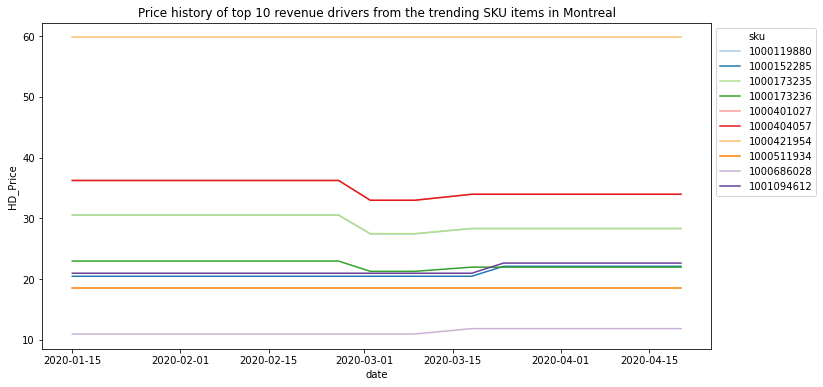

In [201]:
df_Top10_rev_items_SKU_mtl_gp = df_Top10_rev_items_SKU_mtl.groupby(['sku','date'],as_index = False)['HD_Price'].sum()

plt.figure(figsize=(12,6))
sns.lineplot(x='date',y='HD_Price',data=df_Top10_rev_items_SKU_mtl_gp,hue='sku',legend='full',palette='Paired')
plt.title('Price history of top 10 revenue drivers from the trending SKU items in Montreal')
plt.legend(bbox_to_anchor=(1,1))

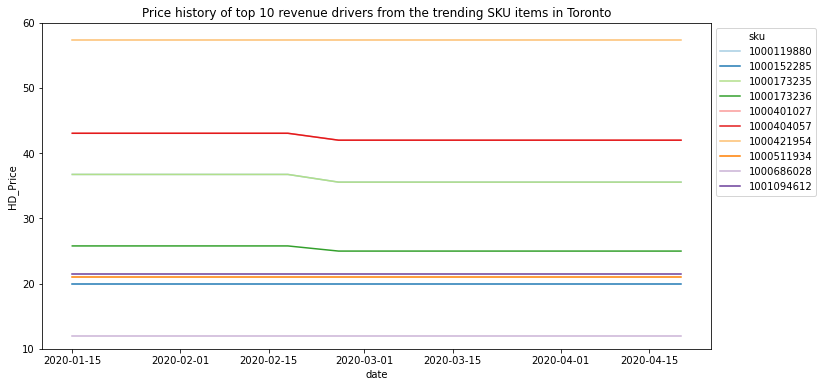

In [202]:
df_Top10_rev_items_SKU_tor_gp = df_Top10_rev_items_SKU_tor.groupby(['sku','date'],as_index = False)['HD_Price'].sum()

plt.figure(figsize=(12,6))
sns.lineplot(x='date',y='HD_Price',data=df_Top10_rev_items_SKU_tor_gp,hue='sku',legend='full',palette='Paired')
plt.title('Price history of top 10 revenue drivers from the trending SKU items in Toronto')
plt.ylim(10,60)
plt.legend(bbox_to_anchor=(1,1))